## 📊 Dataset Overview
This project uses three anonymized datasets representing real-world customer profiles, credit bureau information, and transaction patterns.
### **3️⃣ Transactions Dataset**
Contains platform-wise spending behavior:
- `tran_id`
- `cust_id`
- `tran_date`
- `tran_amount`
- `platform`
- `product_category`
- `payment_type`

**Purpose:**
To understand spending preferences and behavioral patterns for product design.

In [42]:
from src.data_loader import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
loader = DataLoader()
transactions = loader.load_table("transactions")

transactions.head()

transactions loaded successfully. shape: (500000, 7)


,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [43]:
transactions.isnull().sum()

tran_id                0
cust_id                0
tran_date              0
tran_amount            0
platform            4941
product_category       0
payment_type           0
dtype: int64

In [45]:
transactions.platform.value_counts()

platform
Amazon      151443
Flipkart    122660
Alibaba      73584
Meesho       73271
Shopify      39416
Cred         24741
Ebay          9944
Name: count, dtype: int64

In [46]:
transactions.product_category.value_counts()

product_category
Electronics               134535
Fashion & Apparel         116892
Kitchen Appliances         57353
Beauty & Personal Care     56065
Sports                     49704
Home Decor                 38355
Garden & Outdoor           23644
Books                      13635
Toys & Games                9817
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='product_category'>

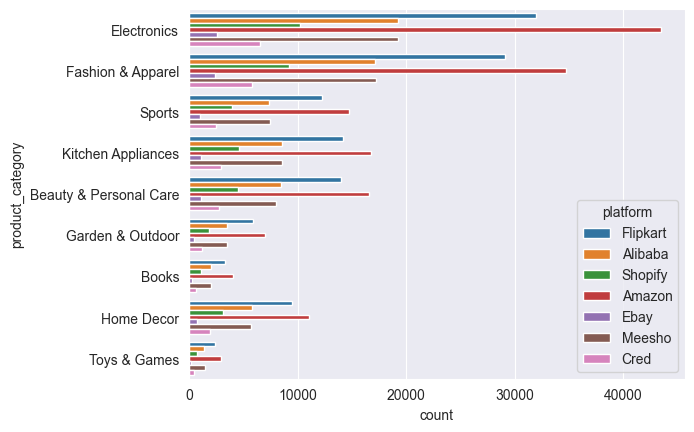

In [47]:
sns.countplot(transactions, hue="platform", y="product_category")

## Handling Missing Values in `platform`

### Observation
The `platform` column contains 4,942 missing values.

Platform distribution shows Amazon as the dominant platform, followed by Flipkart and Alibaba.

Product categories are available for all transactions, and platform usage appears to vary by product category.

### Business Reasoning
Platform selection is typically influenced by product type.
However, in the absence of a deterministic mapping between `product_category` and `platform`, imputing based solely on assumptions may introduce bias.

Since Amazon represents the highest transaction volume across categories, it is statistically the most frequent platform in the dataset.

### Decision
Missing `platform` values will be imputed using the overall mode of the `platform` column (Amazon), ensuring consistency with observed transaction distribution.


In [48]:
transactions.platform.mode()[0]

'Amazon'

In [52]:
transactions["platform"].unique()[:20]


<StringArray>
['Flipkart', 'Alibaba', 'Shopify', 'Amazon', 'Ebay', 'Meesho', 'Cred', nan]
Length: 8, dtype: str

In [53]:
transactions["platform"].value_counts(dropna=False)


platform
Amazon      151443
Flipkart    122660
Alibaba      73584
Meesho       73271
Shopify      39416
Cred         24741
Ebay          9944
NaN           4941
Name: count, dtype: int64

In [54]:
transactions["platform"] = transactions["platform"].fillna(
    transactions["platform"].mode()[0]
)


In [55]:
transactions.isnull().sum()

tran_id             0
cust_id             0
tran_date           0
tran_amount         0
platform            0
product_category    0
payment_type        0
dtype: int64

In [56]:
transactions.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.00000
mean,250000.500000,501.400428,3225.20733
std,144337.711635,288.641924,13098.74276
min,1.000000,1.000000,0.00000
25%,125000.750000,252.000000,64.00000
50%,250000.500000,502.000000,141.00000
75%,375000.250000,752.000000,397.00000
max,500000.000000,1000.000000,69999.00000


In [57]:
transactions[transactions["tran_amount"]==0].shape

(4734, 7)

In [58]:
transactions[transactions["tran_amount"]==0].platform.value_counts()

platform
Amazon    4734
Name: count, dtype: int64

In [59]:
transactions[transactions["tran_amount"]==0].product_category.value_counts()

product_category
Electronics    4734
Name: count, dtype: int64

In [60]:
transactions[transactions["tran_amount"]==0][["platform","product_category","payment_type"]].value_counts()

platform  product_category  payment_type
Amazon    Electronics       Credit Card     4734
Name: count, dtype: int64

## Handling Invalid Values in `tran_amount`

### Observation
The `tran_amount` column contains 4,734 transactions with a value of 0.

All zero-value transactions share the same attributes:

- Platform: Amazon
- Product Category: Electronics
- Payment Type: Credit Card

A transaction amount of 0 is not financially meaningful and likely indicates a data recording issue.

### Business Reasoning
Since these transactions follow a consistent behavioral pattern, replacing them with a global median may distort category-level spending behavior.

To preserve transactional consistency, imputation should be aligned with similar transaction characteristics.

### Decision
For transactions where `tran_amount = 0`, the value is replaced using the median transaction amount of non-zero transactions within the same:

- Platform
- Product Category
- Payment Type

This maintains behavioral integrity and realistic spending patterns.


In [61]:
df_trans= transactions[(transactions.platform == "Amazon") & (transactions.product_category =="Electronics") & (transactions.payment_type =="Credit Card")]
df_trans.shape

(15637, 7)

In [62]:
tran_amount_median=df_trans[df_trans.tran_amount > 0].tran_amount.median()
tran_amount_median

np.float64(554.0)

In [63]:
transactions["tran_amount"] = transactions["tran_amount"].replace(0, tran_amount_median, inplace=True)

In [64]:
transactions[transactions["tran_amount"]==0][["platform","product_category","payment_type"]].value_counts()

Series([], Name: count, dtype: int64)

In [65]:
transactions.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.000000
mean,250000.500000,501.400428,3230.452602
std,144337.711635,288.641924,13097.561071
min,1.000000,1.000000,2.000000
25%,125000.750000,252.000000,66.000000
50%,250000.500000,502.000000,146.000000
75%,375000.250000,752.000000,413.000000
max,500000.000000,1000.000000,69999.000000


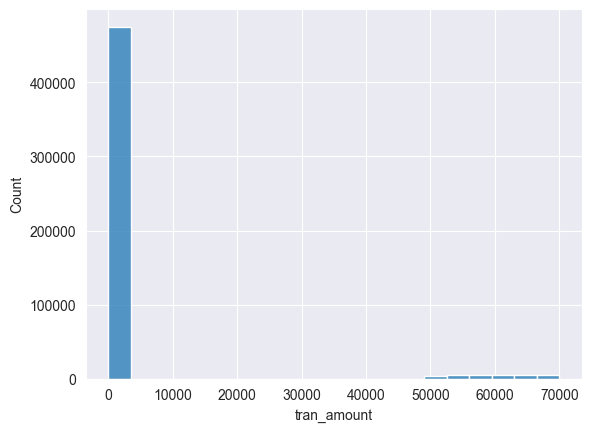

In [66]:
sns.histplot(transactions.tran_amount, bins=20)
plt.show()

## Handling Outliers in `tran_amount`

### Observation
Using the IQR method (with 2 × IQR), the upper bound for valid transaction amounts was calculated as 1,107.

Approximately 25,000 transactions exceed this threshold and are considered outliers.

The lower bound is negative, which is not meaningful for transaction amounts and therefore ignored.

### Business Reasoning
Transaction data is naturally right-skewed, especially for categories like Electronics and Home Decor where high-value purchases are common.

Blindly removing or capping all high transactions may distort genuine spending behavior.

Instead of applying a global cap, transaction amounts should be adjusted relative to their product category to preserve category-level spending characteristics.

### Decision
For transactions exceeding the upper IQR bound, values will be replaced using the average transaction amount of their respective `product_category`.

This approach maintains realistic spending behavior while reducing the impact of extreme outliers on downstream analysis.


In [67]:
Q1, Q3 = transactions["tran_amount"].quantile([0.25, 0.75])

IQR = Q3 - Q1

lower = Q1 - 2*IQR
upper = Q3 + 2*IQR

lower, upper

(-628.0, 1107.0)

In [70]:
tran_outliers= transactions[transactions.tran_amount > upper]
tran_outliers.shape

(25000, 7)

In [71]:
tran_normal = transactions[transactions.tran_amount < upper]
tran_normal.shape

(475000, 7)

In [72]:
tran_mean_per_category = tran_normal.groupby("product_category")["tran_amount"].mean()
tran_mean_per_category

product_category
Beauty & Personal Care     92.167205
Books                      29.553515
Electronics               510.172685
Fashion & Apparel          64.553463
Garden & Outdoor          125.630277
Home Decor                302.487561
Kitchen Appliances        176.773288
Sports                    269.181631
Toys & Games               50.333298
Name: tran_amount, dtype: float64

In [74]:
transactions["tran_amount"] = transactions["tran_amount"].astype(float)


In [75]:
transactions.loc[
    tran_outliers.index,
    "tran_amount"
] = tran_outliers["product_category"].map(tran_mean_per_category)


In [77]:
transactions[transactions.tran_amount > upper].shape

(0, 7)